In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import (
    accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, auc, precision_score, recall_score,
    f1_score, roc_curve, classification_report, roc_auc_score
)
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

In [2]:
# Mounting Drive


## Preprocessing

### Dataset description
UNSW-NB15 is a network intrusion dataset created by the University of New South Wales (UNSW) in Australia. It contains nine different attacks, includes DoS, worms, Backdoors, and Fuzzers. The dataset contains raw network packets. The dataset also has a binary classification of attack category (1/0), with a “label” of 0 representing normal or non-attack and 1 representing any type of attack. The number of records in the training set is 175,341 records and the testing set is 82,332 records from the different types, attack and normal.
https://ieeexplore.ieee.org/document/7348942

The main objective of this project is to develop a machine learning-based intrusion detection system that can predict network intrusion detection (ID).

In [3]:
#We already have a training set and a test set frm the data source. we merge the datasets to clean
#them only once
# Load the training set
train_df = pd.read_parquet('UNSW_NB15_training-set.parquet')
test_df = pd.read_parquet('UNSW_NB15_testing-set.parquet')

# Concatenate the training and test sets
df = pd.concat([train_df, test_df], ignore_index=True)

df.info()

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257673 entries, 0 to 257672
Data columns (total 36 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   dur                257673 non-null  float32 
 1   proto              257673 non-null  object  
 2   service            257673 non-null  category
 3   state              257673 non-null  object  
 4   spkts              257673 non-null  int16   
 5   dpkts              257673 non-null  int16   
 6   sbytes             257673 non-null  int32   
 7   dbytes             257673 non-null  int32   
 8   rate               257673 non-null  float32 
 9   sload              257673 non-null  float32 
 10  dload              257673 non-null  float32 
 11  sloss              257673 non-null  int16   
 12  dloss              257673 non-null  int16   
 13  sinpkt             257673 non-null  float32 
 14  dinpkt             257673 non-null  float32 
 15  sjit               257673 non-null

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sload,...,trans_depth,response_body_len,ct_src_dport_ltm,ct_dst_sport_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,is_sm_ips_ports,attack_cat,label
0,0.000011,udp,-,INT,2,0,496,0,90909.09375,180363632.0,...,0,0,1,1,0,0,0,0,Normal,0
1,0.000008,udp,-,INT,2,0,1762,0,125000.00000,881000000.0,...,0,0,1,1,0,0,0,0,Normal,0
2,0.000005,udp,-,INT,2,0,1068,0,200000.00000,854400000.0,...,0,0,1,1,0,0,0,0,Normal,0
3,0.000006,udp,-,INT,2,0,900,0,166666.65625,600000000.0,...,0,0,2,1,0,0,0,0,Normal,0
4,0.000010,udp,-,INT,2,0,2126,0,100000.00000,850400000.0,...,0,0,2,1,0,0,0,0,Normal,0


In [4]:
print(df.info())
#dataset looks pretty clean, there are no missing values nor dupicates

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257673 entries, 0 to 257672
Data columns (total 36 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   dur                257673 non-null  float32 
 1   proto              257673 non-null  object  
 2   service            257673 non-null  category
 3   state              257673 non-null  object  
 4   spkts              257673 non-null  int16   
 5   dpkts              257673 non-null  int16   
 6   sbytes             257673 non-null  int32   
 7   dbytes             257673 non-null  int32   
 8   rate               257673 non-null  float32 
 9   sload              257673 non-null  float32 
 10  dload              257673 non-null  float32 
 11  sloss              257673 non-null  int16   
 12  dloss              257673 non-null  int16   
 13  sinpkt             257673 non-null  float32 
 14  dinpkt             257673 non-null  float32 
 15  sjit               257673 non-null

In [5]:
df.duplicated().sum()

112451

In [6]:
df.describe()

,dur,spkts,dpkts,sbytes,dbytes,rate,sload,dload,sloss,dloss,...,dmean,trans_depth,response_body_len,ct_src_dport_ltm,ct_dst_sport_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,is_sm_ips_ports,label
count,257673.000000,257673.000000,257673.000000,2.576730e+05,2.576730e+05,257673.000000,2.576730e+05,2.576730e+05,257673.000000,257673.000000,...,257673.000000,257673.000000,2.576730e+05,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000
mean,1.246715,19.777144,18.514703,8.572952e+03,1.438729e+04,91253.914062,7.060869e+07,6.582144e+05,4.889317,6.743691,...,121.649703,0.102242,1.968900e+03,5.238271,4.032677,0.012819,0.012850,0.132005,0.014274,0.639077
std,5.974306,135.947152,111.985965,1.737739e+05,1.461993e+05,160344.640625,1.857312e+08,2.412372e+06,65.574953,53.702222,...,254.041013,0.710593,4.962523e+04,8.160822,5.831515,0.116091,0.116421,0.681854,0.118618,0.480269
min,0.000000,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,30.789276,1.231800e+04,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.004285,4.000000,2.000000,5.280000e+02,1.780000e+02,2955.664795,7.439423e+05,1.747441e+03,0.000000,0.000000,...,44.000000,0.000000,0.000000e+00,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.685777,12.000000,10.000000,1.362000e+03,1.064000e+03,125000.000000,8.000000e+07,2.210538e+04,3.000000,2.000000,...,89.000000,0.000000,0.000000e+00,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,59.999989,10646.000000,11018.000000,1.435577e+07,1.465753e+07,1000000.000000,5.988000e+09,2.242273e+07,5319.000000,5507.000000,...,1500.000000,172.000000,6.558056e+06,59.000000,46.000000,4.000000,4.000000,30.000000,1.000000,1.000000


In [7]:
unique_services = df['service'].unique()
unique_attack_cat = df['attack_cat'].unique()
unique_proto = df["proto"].unique()
unique_state = df["state"].unique()

categories = [
    ("Types of 'service' observations:", unique_services),
    ("Types of attack:", unique_attack_cat),
    ("Types of protocol:", unique_proto),
    ("Types of states:", unique_state)
]
[print(f"{title}\n{', '.join(values)}\n") for title, values in categories]

Types of 'service' observations:
-, http, ftp, ftp-data, smtp, pop3, dns, snmp, ssl, dhcp, irc, radius, ssh

Types of attack:
Normal, Reconnaissance, Backdoor, DoS, Exploits, Analysis, Fuzzers, Worms, Shellcode, Generic

Types of protocol:
udp, arp, tcp, igmp, ospf, sctp, gre, ggp, ip, ipnip, st2, argus, chaos, egp, emcon, nvp, pup, xnet, mux, dcn, hmp, prm, trunk-1, trunk-2, xns-idp, leaf-1, leaf-2, irtp, rdp, netblt, mfe-nsp, merit-inp, 3pc, idpr, ddp, idpr-cmtp, tp++, ipv6, sdrp, ipv6-frag, ipv6-route, idrp, mhrp, i-nlsp, rvd, mobile, narp, skip, tlsp, ipv6-no, any, ipv6-opts, cftp, sat-expak, ippc, kryptolan, sat-mon, cpnx, wsn, pvp, br-sat-mon, sun-nd, wb-mon, vmtp, ttp, vines, nsfnet-igp, dgp, eigrp, tcf, sprite-rpc, larp, mtp, ax.25, ipip, aes-sp3-d, micp, encap, pri-enc, gmtp, ifmp, pnni, qnx, scps, cbt, bbn-rcc, igp, bna, swipe, visa, ipcv, cphb, iso-tp4, wb-expak, sep, secure-vmtp, xtp, il, rsvp, unas, fc, iso-ip, etherip, pim, aris, a/n, ipcomp, snp, compaq-peer, ipx-n-ip, p

[None, None, None, None]

In [8]:
#remove "-" entries from service
df = df[df['service'] != '-']

In [9]:
df1=df.copy() # To be used later

#drop irrelevant columns, hence id and the target column attack_category
drop_column = ["attack_cat"]
df.drop(drop_column, axis=1, inplace=True)

In [10]:
# apply one-hot-encoding to categorical data (service,proto,state)
df_categorical = df.select_dtypes(exclude=[np.number])
label = LabelEncoder()
print(df_categorical.columns)
for feature in df_categorical.columns:
    df[feature] = label.fit_transform(df[feature])

Index(['proto', 'service', 'state'], dtype='object')


In [11]:
df #now our dataframe is the table without id and attack_cat (y), and where all variables
#are numerical after encoding

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sload,...,dmean,trans_depth,response_body_len,ct_src_dport_ltm,ct_dst_sport_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,is_sm_ips_ports,label
35,0.983874,0,4,2,10,8,816,1172,17.278635,5.976375e+03,...,147,1,184,1,1,0,0,1,0,0
40,1.535254,0,4,2,10,10,826,1266,12.375802,3.876883e+03,...,127,1,187,1,1,0,0,1,0,0
45,1.059359,0,4,2,10,8,830,1134,16.047441,5.641147e+03,...,142,1,165,1,1,0,0,1,0,0
49,0.990548,0,4,2,10,10,804,1414,19.181301,5.847268e+03,...,141,1,261,1,1,0,0,1,0,0
72,1.303518,0,4,2,12,8,898,1120,14.575939,5.057084e+03,...,140,1,157,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257667,0.000006,1,1,3,2,0,114,0,166666.656250,7.600000e+07,...,0,0,0,33,17,0,0,0,0,1
257668,0.000009,1,1,3,2,0,114,0,111111.109375,5.066666e+07,...,0,0,0,24,13,0,0,0,0,1
257670,0.000009,1,1,3,2,0,114,0,111111.109375,5.066666e+07,...,0,0,0,3,3,0,0,0,0,1
257671,0.000009,1,1,3,2,0,114,0,111111.109375,5.066666e+07,...,0,0,0,30,14,0,0,0,0,1


In [12]:
column_names = [col for col in df.columns]
column_names

['dur',
 'proto',
 'service',
 'state',
 'spkts',
 'dpkts',
 'sbytes',
 'dbytes',
 'rate',
 'sload',
 'dload',
 'sloss',
 'dloss',
 'sinpkt',
 'dinpkt',
 'sjit',
 'djit',
 'swin',
 'stcpb',
 'dtcpb',
 'dwin',
 'tcprtt',
 'synack',
 'ackdat',
 'smean',
 'dmean',
 'trans_depth',
 'response_body_len',
 'ct_src_dport_ltm',
 'ct_dst_sport_ltm',
 'is_ftp_login',
 'ct_ftp_cmd',
 'ct_flw_http_mthd',
 'is_sm_ips_ports',
 'label']

In [74]:
#Standardize variables
scaler = StandardScaler()
numerical_columns = df.select_dtypes(include=[np.number]).columns

# Df & df1
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

df[numerical_columns]

joblib.dump(scaler,'label1.joblib')

['label1.joblib']

## EDA

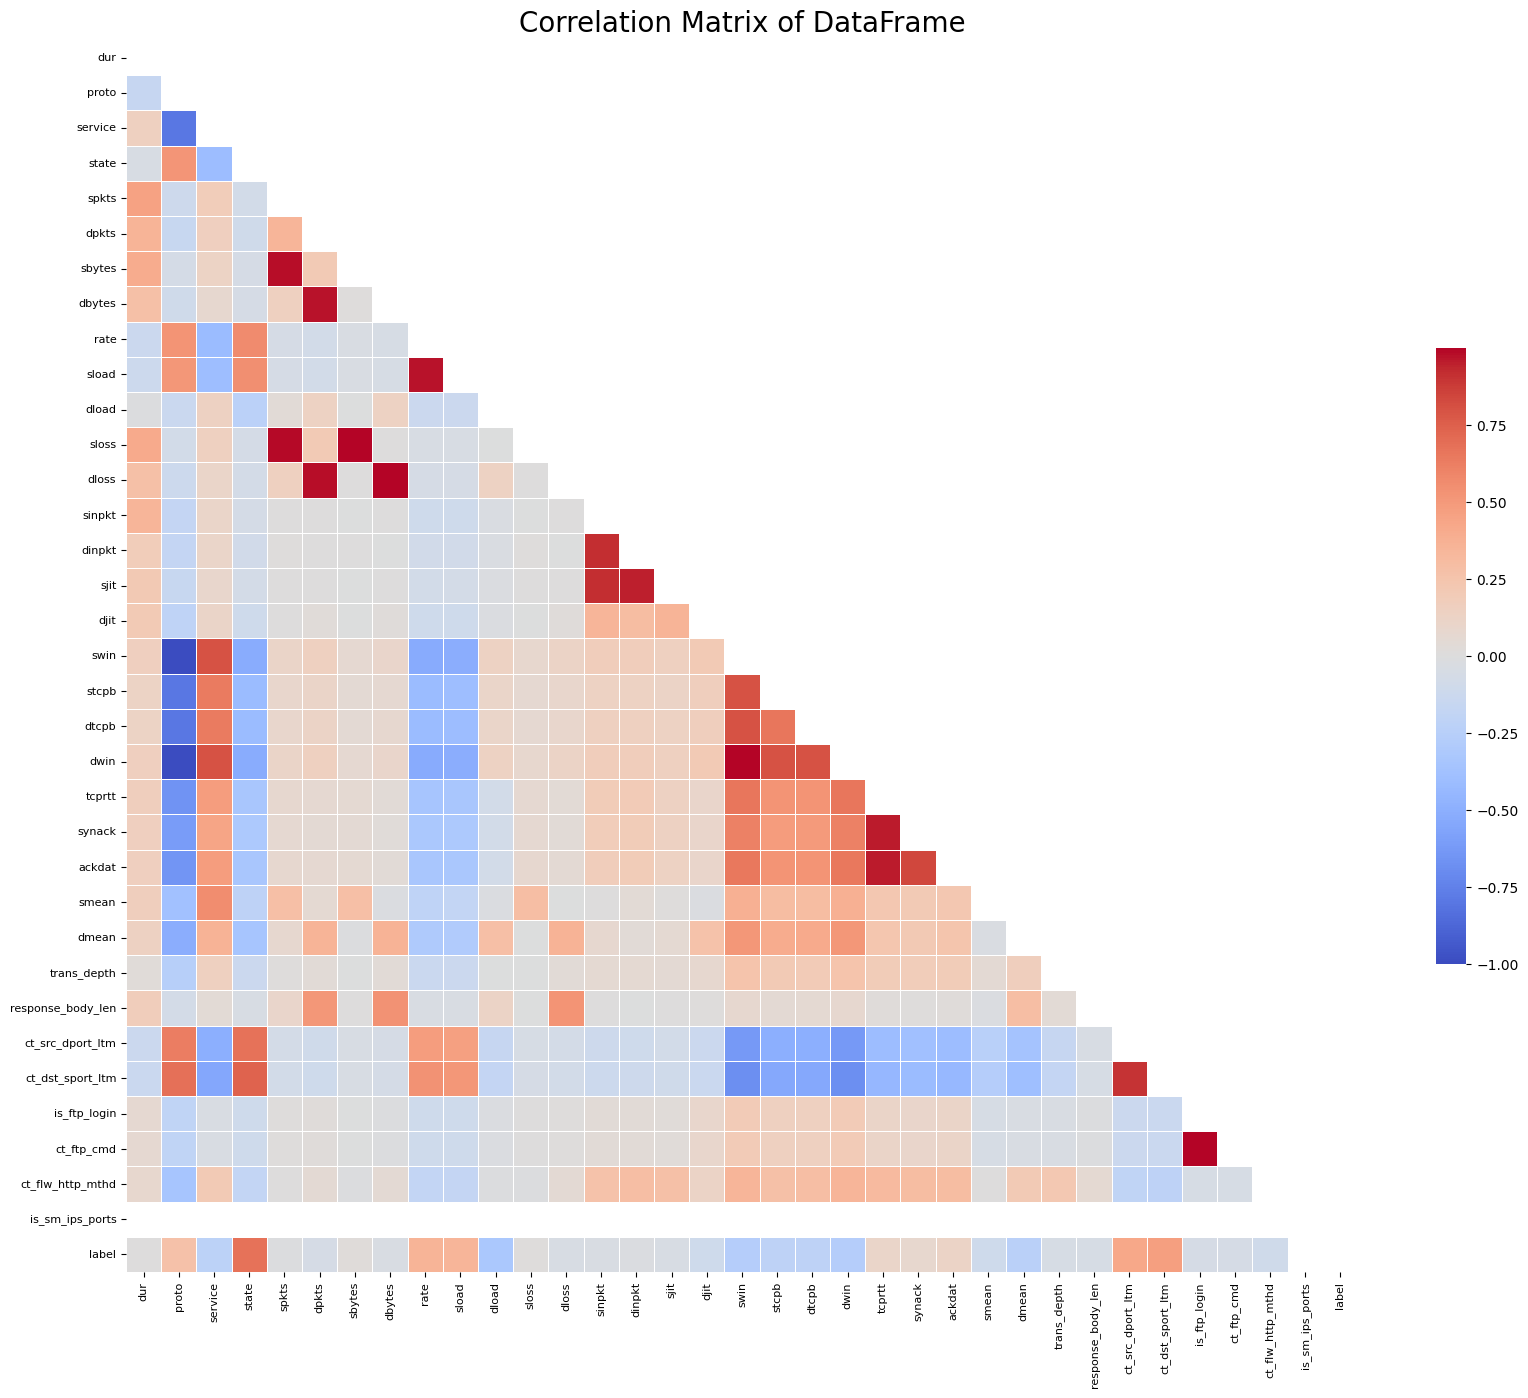

In [14]:
# Calculate the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(20, 16))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=False,
            ax=ax)

plt.title("Correlation Matrix of DataFrame", fontsize=20)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.show()

In [15]:
columns = df.columns.tolist()
corr = df.corr()
correlation_threshold = 0.98

# Initialize a list to store correlated variables
correlated_vars = []

# Iterate through the columns to find highly correlated pairs
for i in range(len(columns) - 1):
    for j in range(i + 1, len(columns)):
        if corr[columns[i]][columns[j]] >= correlation_threshold:
            print(f"Highly correlated: {columns[i]} and {columns[j]} (Correlation: {corr[columns[i]][columns[j]]:.2f})")
            correlated_vars.append(columns[j])

# Remove the highly correlated variables from the DataFrame
df_filtered = df.drop(columns=correlated_vars)

Highly correlated: spkts and sbytes (Correlation: 0.98)
Highly correlated: spkts and sloss (Correlation: 0.98)
Highly correlated: sbytes and sloss (Correlation: 1.00)
Highly correlated: dbytes and dloss (Correlation: 1.00)
Highly correlated: swin and dwin (Correlation: 1.00)
Highly correlated: is_ftp_login and ct_ftp_cmd (Correlation: 1.00)


In [16]:
# Calculate skewness for each column and apply log transformation
df_numeric = df.drop(['state', 'proto', 'service'], axis=1).apply(pd.to_numeric, errors='coerce')
# Calculate skewness for each column
skewness = df_numeric.apply(lambda x: x.skew())

# Print skewness for each column
print("Skewness for each column:")
for column, skew_value in skewness.items():
    print(f"{column}: {skew_value:.2f}")

# List of columns with values higher than 40
columns_to_transform = skewness[skewness > 40].index

# Apply log transformation to columns with values higher than 40
df_numeric[columns_to_transform] = df_numeric[columns_to_transform].applymap(lambda x: np.log1p(x) if x > 40 else x)

# Add the transformed columns back to the original dataset 'df'
df[columns_to_transform] = df_numeric[columns_to_transform]


Skewness for each column:
dur: 11.79
spkts: 32.50
dpkts: 43.17
sbytes: 34.28
dbytes: 44.82
rate: 3.09
sload: 3.95
dload: 11.50
sloss: 34.13
dloss: 46.76
sinpkt: 26.73
dinpkt: 31.48
sjit: 28.62
djit: 42.64
swin: 0.37
stcpb: 1.23
dtcpb: 1.23
dwin: 0.37
tcprtt: 2.04
synack: 2.27
ackdat: 3.07
smean: 3.76
dmean: 3.20
trans_depth: 121.08
response_body_len: 53.28
ct_src_dport_ltm: 1.26
ct_dst_sport_ltm: 0.73
is_ftp_login: 6.87
ct_ftp_cmd: 6.88
ct_flw_http_mthd: 14.60
is_sm_ips_ports: 0.00
label: -1.15


C:\Users\badal\AppData\Local\Temp\ipykernel_21740\1312649052.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_numeric[columns_to_transform] = df_numeric[columns_to_transform].applymap(lambda x: np.log1p(x) if x > 40 else x)


In [17]:
# Print skewness for each column again
skewness = df.apply(lambda x: x.skew())
print("Skewness for each column:")
for column, skew_value in skewness.items():
    print(f"{column}: {skew_value:.2f}")

Skewness for each column:
dur: 11.79
proto: -0.37
service: 1.61
state: -0.62
spkts: 32.50
dpkts: 21.07
sbytes: 34.28
dbytes: 23.17
rate: 3.09
sload: 3.95
dload: 11.50
sloss: 34.13
dloss: 20.85
sinpkt: 26.73
dinpkt: 31.48
sjit: 28.62
djit: 20.79
swin: 0.37
stcpb: 1.23
dtcpb: 1.23
dwin: 0.37
tcprtt: 2.04
synack: 2.27
ackdat: 3.07
smean: 3.76
dmean: 3.20
trans_depth: 12.64
response_body_len: 17.60
ct_src_dport_ltm: 1.26
ct_dst_sport_ltm: 0.73
is_ftp_login: 6.87
ct_ftp_cmd: 6.88
ct_flw_http_mthd: 14.60
is_sm_ips_ports: 0.00
label: -1.15


In [18]:
# Define the color palette for visualisations
color_palette = ['#f94144', '#f3722c', '#f8961e', '#f9844a', '#f9c74f', '#90be6d', '#43aa8b', '#4d908e', '#577590', '#277da1']

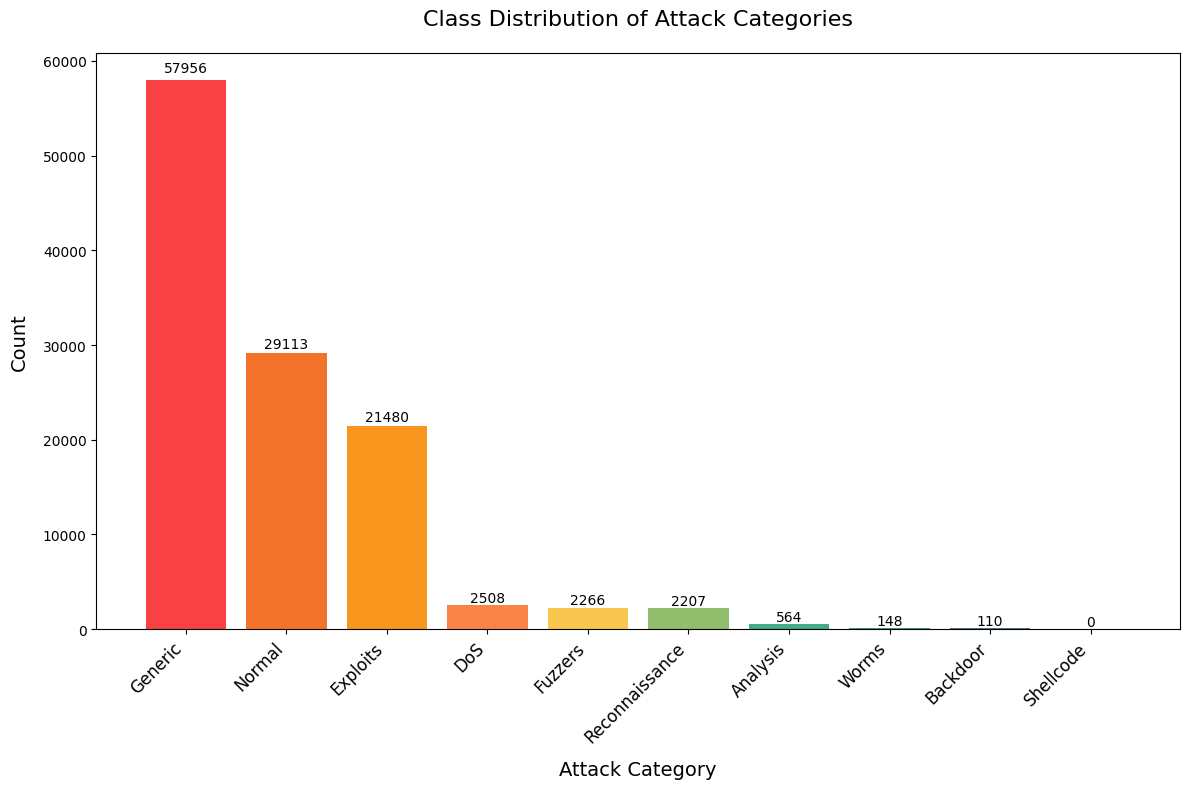

In [19]:
plt.figure(figsize=(12, 8))
attack_cat_counts = df1['attack_cat'].value_counts()
colors = color_palette[:len(attack_cat_counts)]

bars = plt.bar(attack_cat_counts.index, attack_cat_counts.values, color=colors)
plt.xlabel('Attack Category', fontsize=14, labelpad=10)
plt.ylabel('Count', fontsize=14, labelpad=10)
plt.title('Class Distribution of Attack Categories', fontsize=16, pad=20)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=12)

# Add text labels above the bars
for bar, count in zip(bars, attack_cat_counts.values):
    y_offset = count * 0.01
    plt.text(bar.get_x() + bar.get_width() / 2, count + y_offset,
             str(count), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


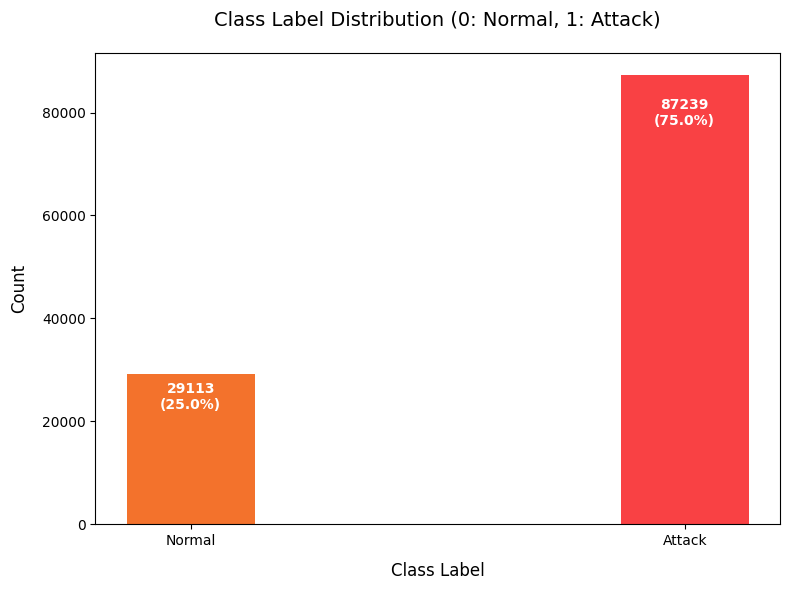

In [20]:
# Count the occurrences of each class label
label_counts = df['label'].value_counts()

# Calculate the percentage of each class label
label_percentages = label_counts / len(df) * 100

plt.figure(figsize=(8, 6))
bars = plt.bar(label_counts.index, label_counts.values, color=color_palette[:2], width=0.6)
plt.xlabel('Class Label', fontsize=12, labelpad=10)
plt.ylabel('Count', fontsize=12, labelpad=10)
plt.title('Class Label Distribution (0: Normal, 1: Attack)', fontsize=14, pad=20)
plt.xticks(label_counts.index, ['Attack', 'Normal'], fontsize=10)

# Add count and percentage labels on the bars
for bar, percentage in zip(bars, label_percentages):
    count = bar.get_height()
    label_y_position = count - (count * 0.05)
    plt.text(bar.get_x() + bar.get_width() / 2, label_y_position, f'{count}\n({percentage:.1f}%)',
             ha='center', va='top', color='white', fontsize=10, weight='bold')

plt.tight_layout()
plt.show()

C:\Users\badal\AppData\Local\Temp\ipykernel_21740\2131961544.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  service_attack_counts = df1.groupby(['service', 'attack_cat']).size().unstack(fill_value=0)


<Figure size 1800x800 with 0 Axes>

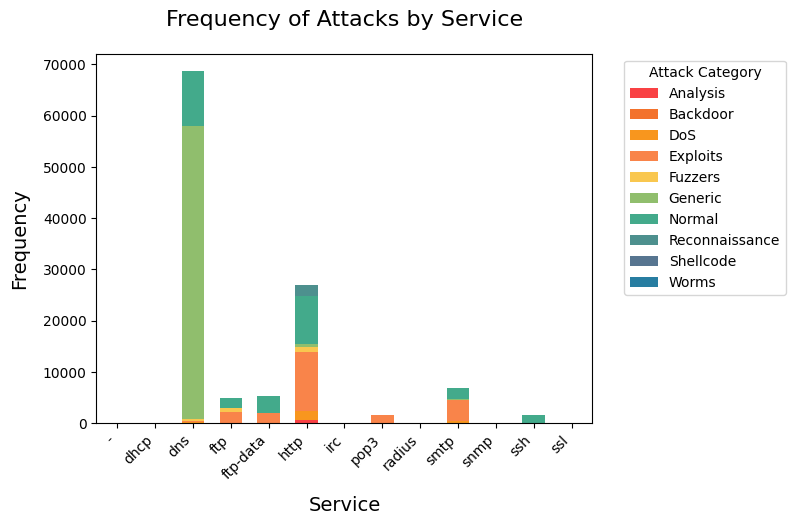

In [21]:
plt.figure(figsize=(18, 8))
service_attack_counts = df1.groupby(['service', 'attack_cat']).size().unstack(fill_value=0)

# Plot the bar
ax = service_attack_counts.plot(kind='bar', stacked=True, color=color_palette, width=0.6)
plt.title('Frequency of Attacks by Service', fontsize=16, pad=20)
plt.xlabel('Service', fontsize=14, labelpad=10)
plt.ylabel('Frequency', fontsize=14, labelpad=10)

# Rotate the x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=10)

# Plot the legend
plt.legend(title='Attack Category', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

C:\Users\badal\AppData\Local\Temp\ipykernel_21740\3036996579.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  service_attack_counts = df1.groupby(['proto', 'attack_cat']).size().unstack(fill_value=0)


<Figure size 1800x800 with 0 Axes>

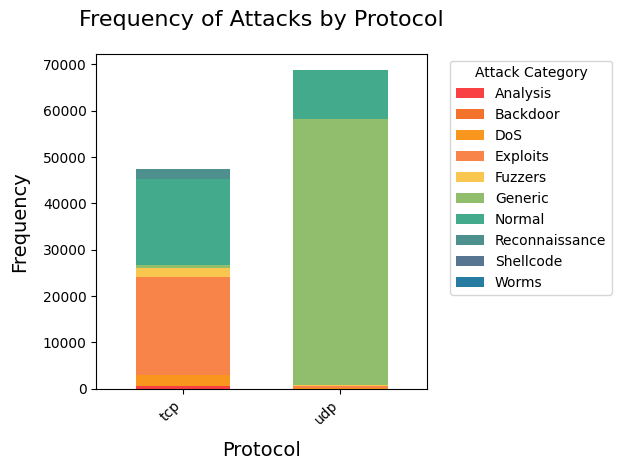

In [22]:
# Group the data by 'proto' and 'attack_cat' columns and count the frequency of attacks
service_attack_counts = df1.groupby(['proto', 'attack_cat']).size().unstack(fill_value=0)

# Set the figure size to be larger than default for clarity
plt.figure(figsize=(18, 8))

# Plot the bar chart h
ax = service_attack_counts.plot(kind='bar', stacked=True, color=color_palette, width=0.6)
plt.title('Frequency of Attacks by Protocol', fontsize=16, pad=20)
plt.xlabel('Protocol', fontsize=14, labelpad=10)
plt.ylabel('Frequency', fontsize=14, labelpad=10)

# Rotate the x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=10)

# Plot the legend
plt.legend(title='Attack Category', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

# Implement tight_layout
plt.tight_layout()
plt.show()

### Feature Distribution

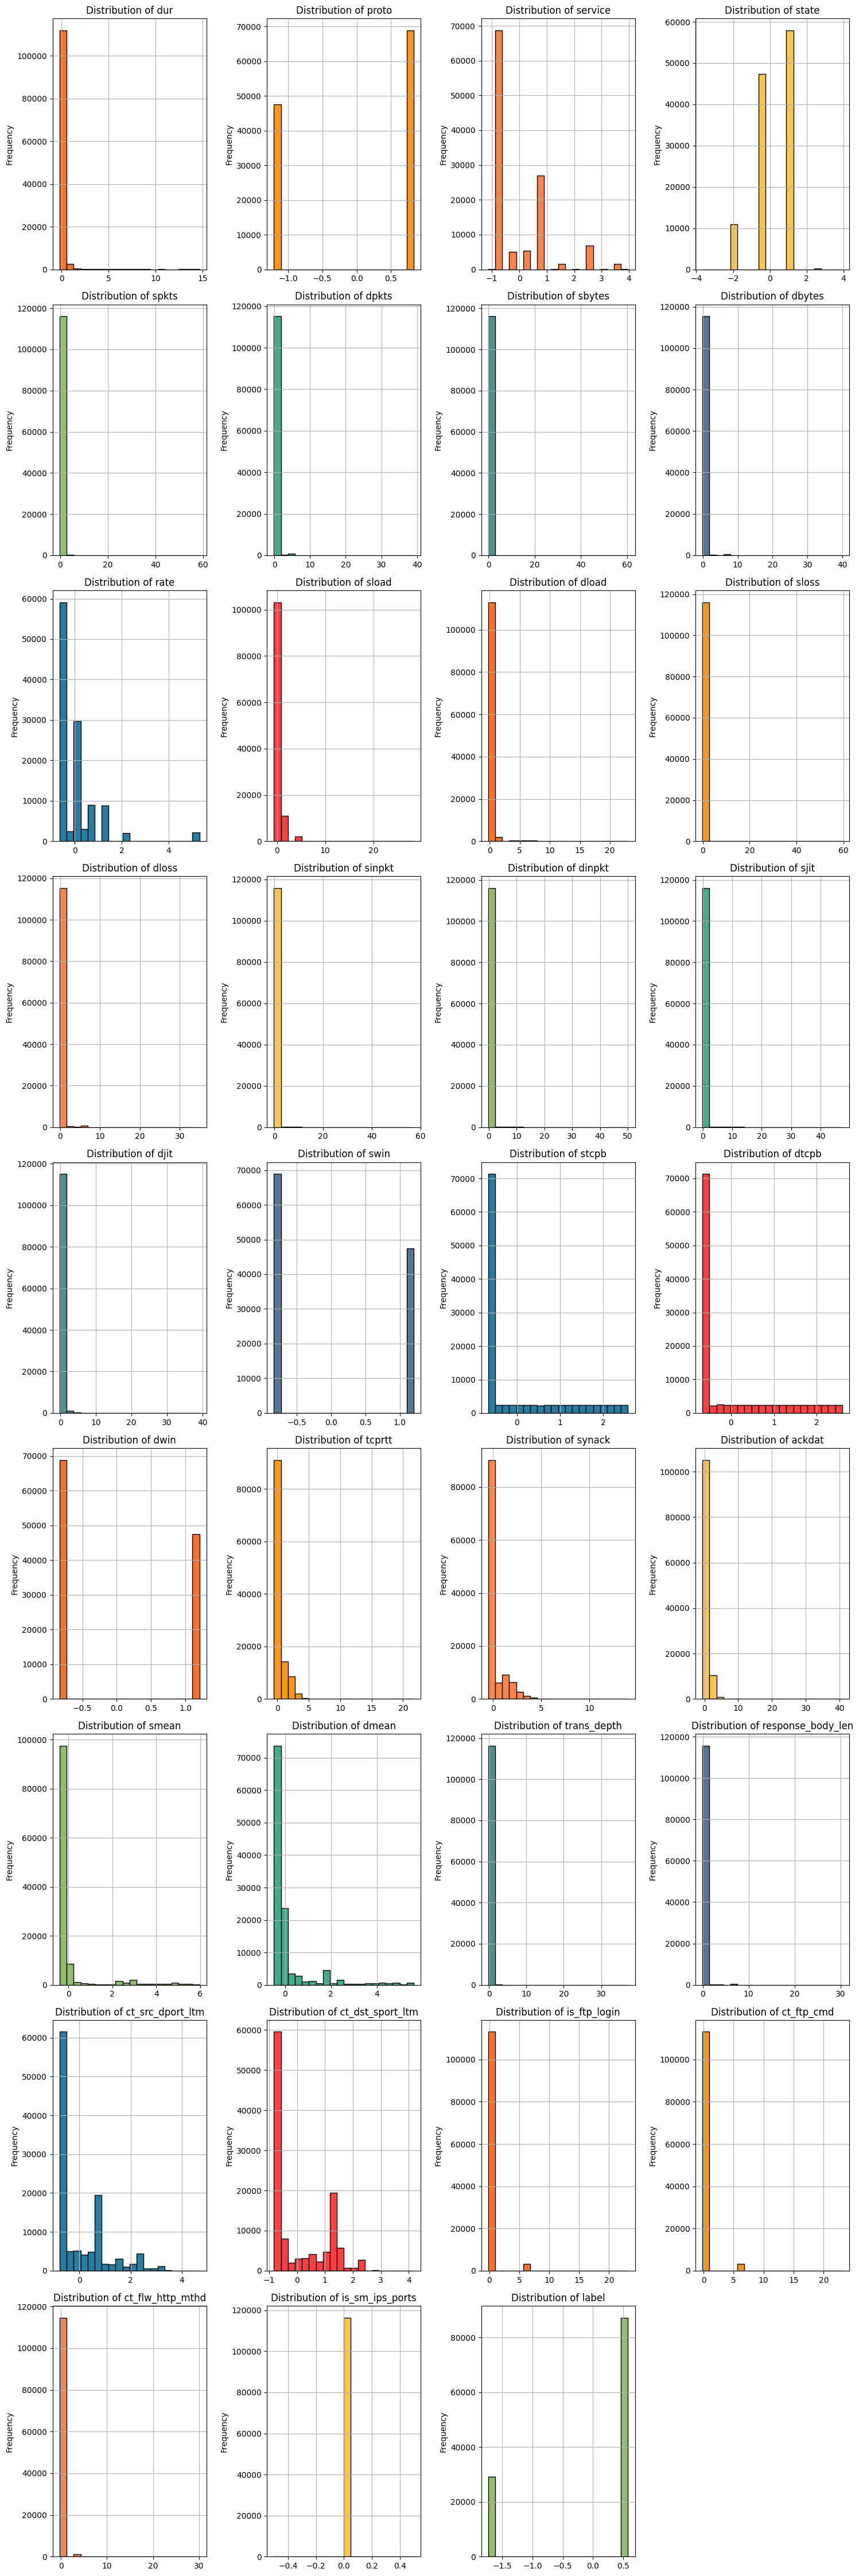

In [23]:
# Calculate the number of rows and columns for subplots
num_rows = (len(numerical_columns) + 3) // 4
num_cols = min(len(numerical_columns), 4)

# Plot histograms for numerical features
plt.figure(figsize=(15, 5 * num_rows))
for i, column in enumerate(numerical_columns, 1):
    ax = plt.subplot(num_rows, num_cols, i)
    df[column].hist(bins=20, color=color_palette[i % len(color_palette)], edgecolor='k')
    ax.set_title(f'Distribution of {column}', fontsize=12)
    ax.set_xlabel('')
    ax.set_ylabel('Frequency', fontsize=10)

plt.tight_layout()
plt.show()

### Categorical Features:


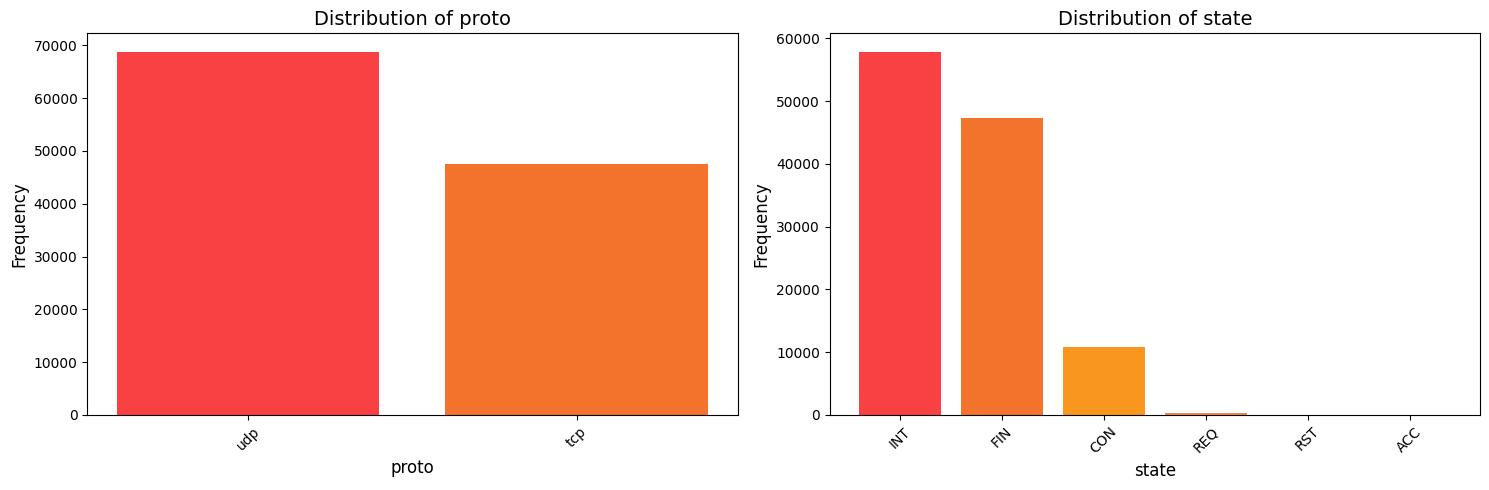

In [24]:
categorical_columns = df1.select_dtypes(include=['object']).columns

if len(categorical_columns) > 0:
    num_plots_per_line = 2
    num_plots = len(categorical_columns)
    num_lines = num_plots // num_plots_per_line + (num_plots % num_plots_per_line > 0)

    # Create subplots for count plots
    fig, axes = plt.subplots(num_lines, num_plots_per_line, figsize=(15, 5 * num_lines), squeeze=False)

    # Create count plots for each categorical feature, with unique colors for each bar
    for i, column in enumerate(categorical_columns):
        row = i // num_plots_per_line
        col = i % num_plots_per_line
        value_counts = df1[column].value_counts()
        bars = axes[row, col].bar(value_counts.index, value_counts.values, color=color_palette[:len(value_counts)])
        axes[row, col].set_title(f'Distribution of {column}', fontsize=14)
        axes[row, col].set_xlabel(column, fontsize=12)
        axes[row, col].set_ylabel('Frequency', fontsize=12)
        axes[row, col].tick_params(axis='x', rotation=45)
        axes[row, col].tick_params(axis='y', labelsize=10)

    # Adjust the layout
    plt.tight_layout()
    plt.show()
else:
    print("No categorical columns found in the DataFrame.")


### Correlation Analysis (Numerical Features):


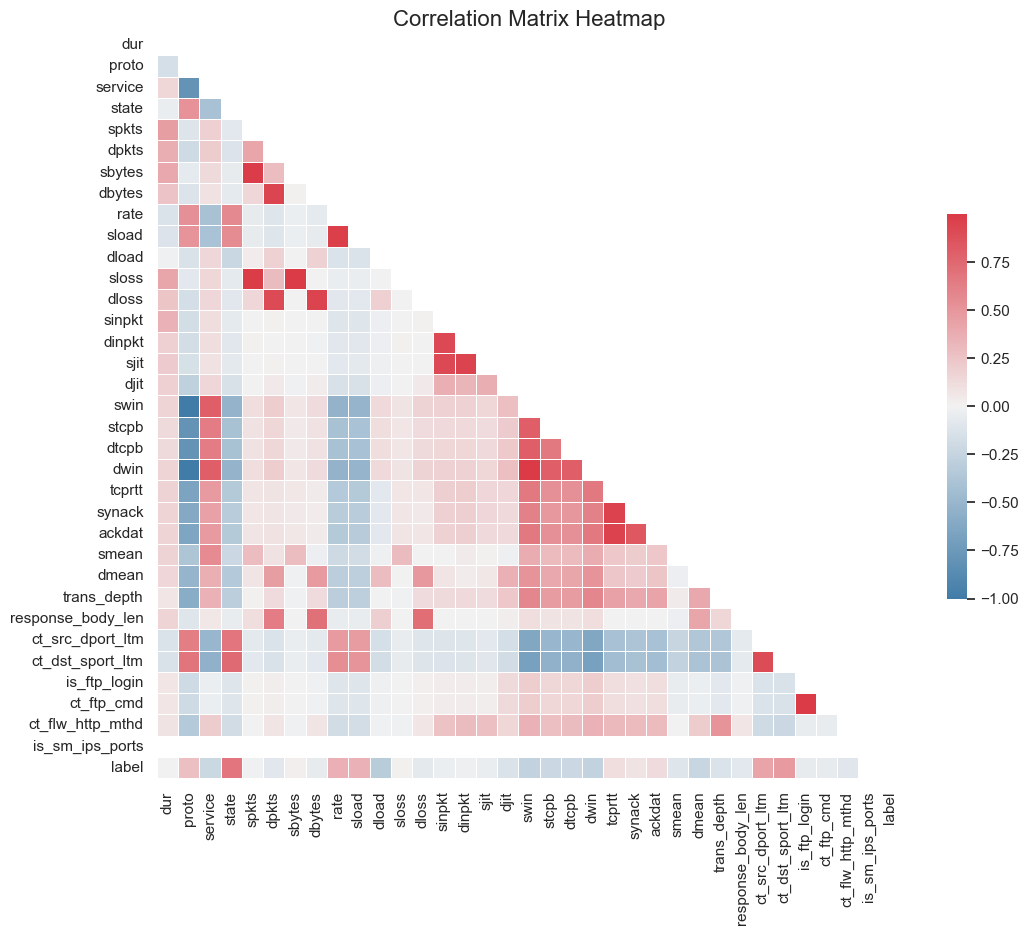

In [25]:
# Calculate the correlation matrix
correlation_matrix = df[numerical_columns].corr()

# Set the seaborn style
sns.set(style="white")

# Increase the figure size for better visibility
plt.figure(figsize=(12, 10))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Use a blue color palette which is more suitable for the diverging range of correlations
cmap = sns.diverging_palette(240, 10, as_cmap=True)

# Draw the heatmap with the mask and the specified aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, annot=False, fmt=".2f",
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title("Correlation Matrix Heatmap", fontsize=16)
plt.show()


### Outliers

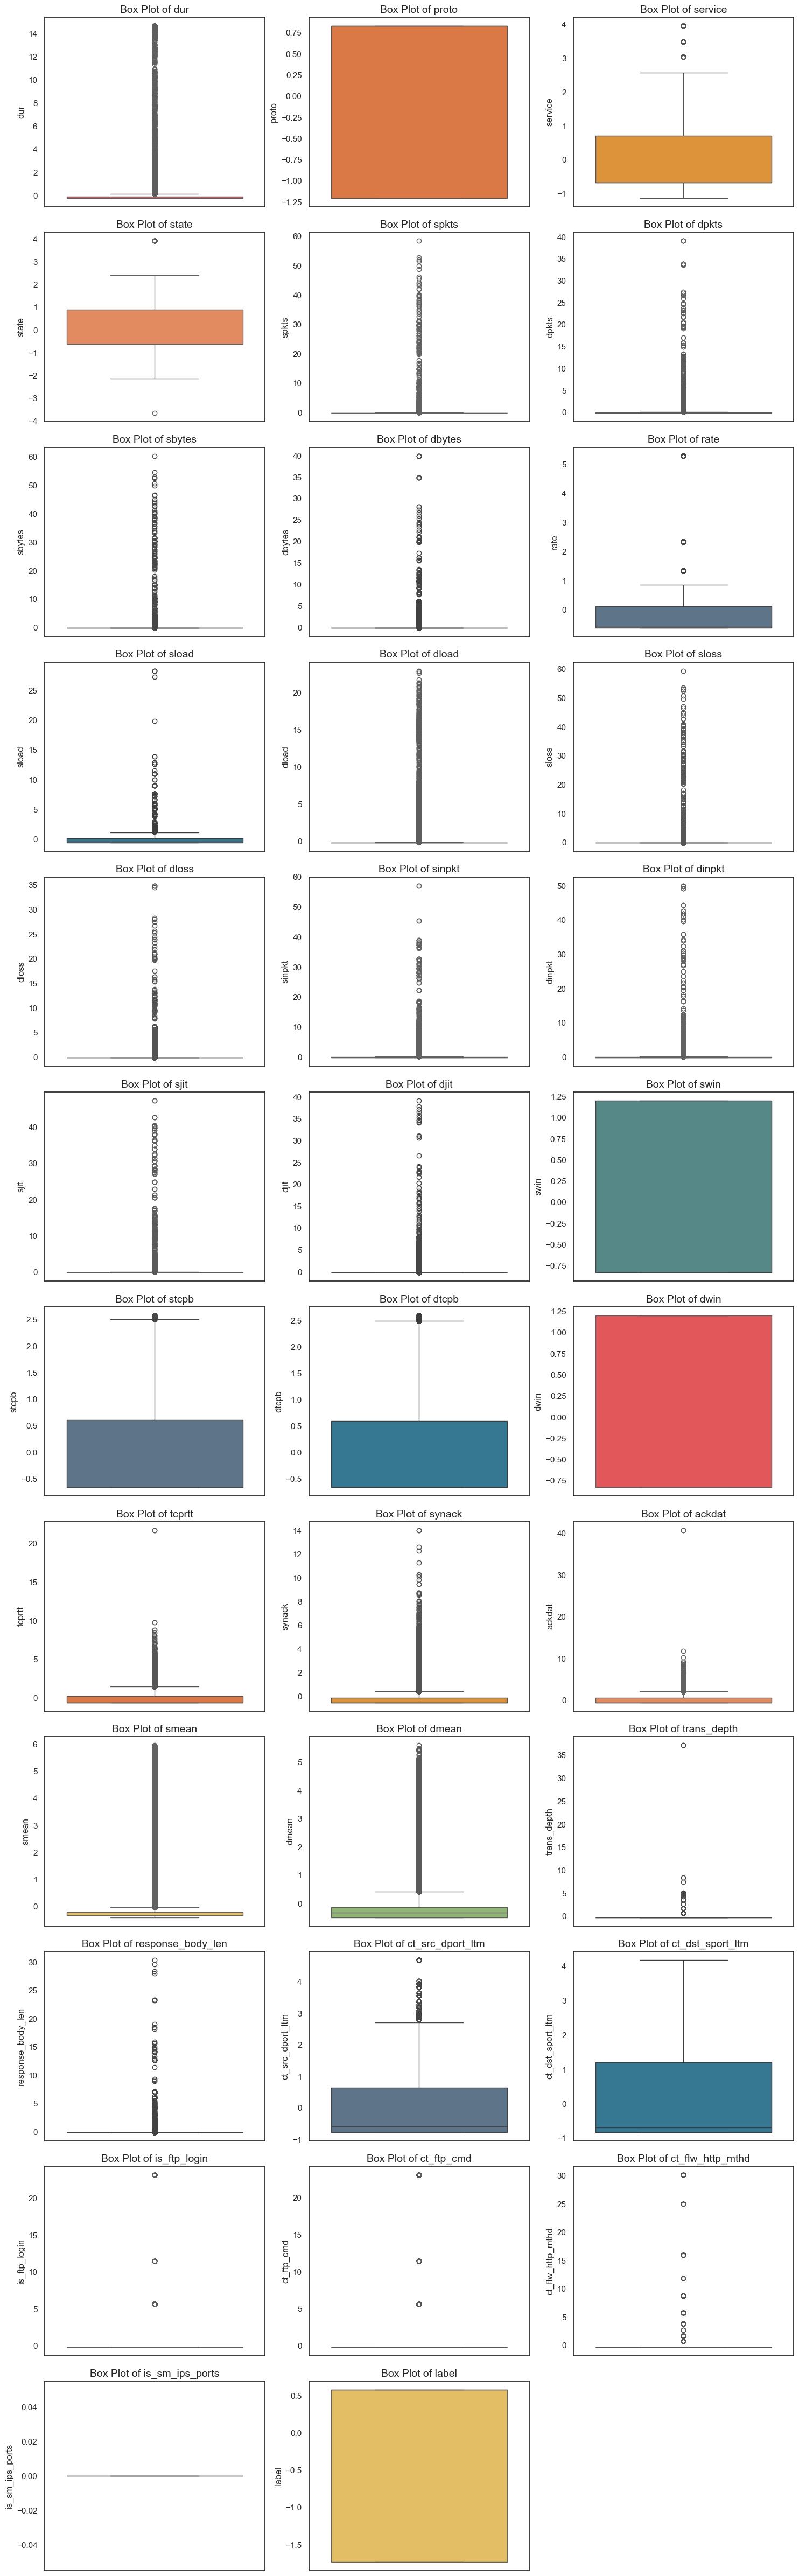

In [26]:
# Set the number of numerical columns per row and the figure size
num_plots_per_row = 3
num_plots = len(numerical_columns)
num_rows = (num_plots - 1) // num_plots_per_row + 1
fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(5 * num_plots_per_row, 4 * num_rows), squeeze=False)

# Create box plots for each numerical feature
for i, column in enumerate(numerical_columns):
    row = i // num_plots_per_row
    col = i % num_plots_per_row
    sns.boxplot(data=df, y=column, ax=axes[row, col], color=color_palette[i % len(color_palette)])
    axes[row, col].set_title(f'Box Plot of {column}', fontsize=14)
    axes[row, col].set_xlabel("")
    axes[row, col].set_ylabel(column, fontsize=12)

# Remove any empty subplots
for i in range(num_plots, num_rows * num_plots_per_row):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


# Models

In [27]:
# Create a LabelEncoder
label_encoder = LabelEncoder()

# Encode the 'label' column
df['label'] = label_encoder.fit_transform(df['label'])

# 'label' contains 0 for no attack and 1 for an attack

In [58]:
# Split Data into Features (X) and Target (y)
X = df.drop(['label'], axis=1)
y = df['label']

# Saving column names
original_feature_names = X.columns

# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split X_train and y_train to create a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit on training set only
X_train = scaler.fit_transform(X_train)

# Apply transform to the test set
X_test = scaler.transform(X_test)

# Apply transform to the validation and test sets
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train.shape
import joblib

joblib.dump(scaler,'labelscaler.joblib')

C:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


['labelscaler.joblib']

# Binary Classifiers (Attack or no Attack)

## Logistic Regression

In [29]:
# Train the model
model = LogisticRegression(max_iter=1000).fit(X_train, y_train)

# Predict on validation set
y_val_predictions = model.predict(X_val)

# Predict on test set
y_test_predictions = model.predict(X_test)
 
# Calculate performance metrics for validation set
accuracy_val = accuracy_score(y_val, y_val_predictions)
recall_val = recall_score(y_val, y_val_predictions, average='weighted')
precision_val = precision_score(y_val, y_val_predictions, average='weighted')
f1s_val = f1_score(y_val, y_val_predictions, average='weighted')

# Calculate performance metrics for test set
accuracy_test = accuracy_score(y_test, y_test_predictions)
recall_test = recall_score(y_test, y_test_predi]ctions, average='weighted')
precision_test = precision_score(y_test, y_test_predictions, average='weighted')
f1s_test = f1_score(y_test, y_test_predictions, average='weighted')

# Print performance metrics for validation set
print("Validation Set Performance:")
print("Accuracy: " + "{:.2%}".format(accuracy_val))
print("Recall: " + "{:.2%}".format(recall_val))
print("Precision: " + "{:.2%}".format(precision_val))
print("F1-Score: " + "{:.2%}".format(f1s_val))

# Print performance metrics for test set
print("\nTest Set Performance:")
print("Accuracy: " + "{:.2%}".format(accuracy_test))
print("Recall: " + "{:.2%}".format(recall_test))
print("Precision: " + "{:.2%}".format(precision_test))
print("F1-Score: " + "{:.2%}".format(f1s_test))

Validation Set Performance:
Accuracy: 94.41%
Recall: 94.41%
Precision: 94.34%
F1-Score: 94.34%

Test Set Performance:
Accuracy: 93.93%
Recall: 93.93%
Precision: 93.86%
F1-Score: 93.85%


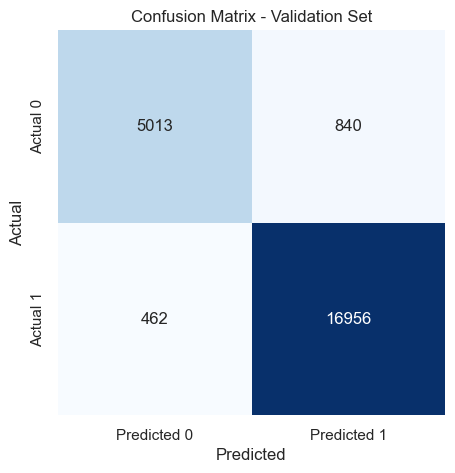

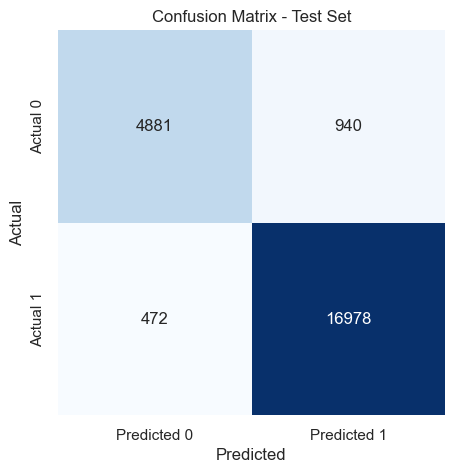

In [30]:
# Predictions on validation set
y_val_pred = model.predict(X_val)

# Predictions on test set
y_test_pred = model.predict(X_test)

# Confusion matrices
conf_matrix_val = confusion_matrix(y_val, y_val_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

# Visualization for the validation set
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Validation Set')
plt.show()

# Visualization for the test set
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Set')
plt.show()


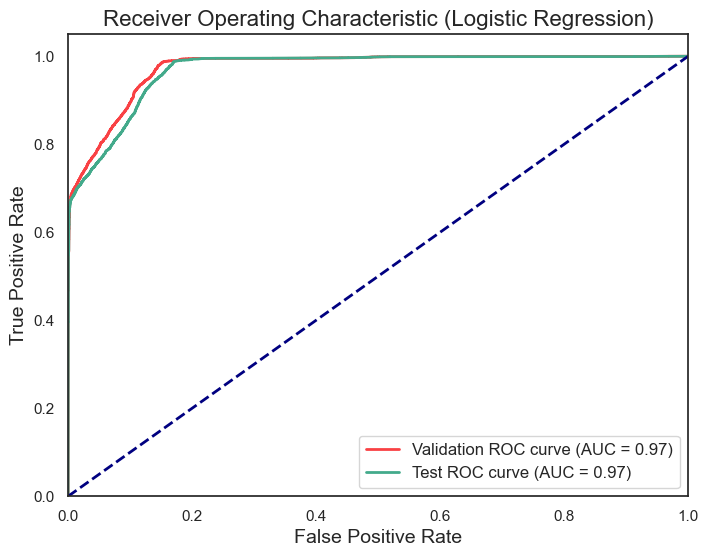

In [31]:
# Predicted probabilities for the validation set
y_val_pred_prob = model.predict_proba(X_val)[:, 1]

# Compute ROC curve and ROC area for the validation set
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred_prob)
roc_auc_val = auc(fpr_val, tpr_val)

# Predicted probabilities for the test set
y_test_pred_prob = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for the test set
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve for the validation set
plt.figure(figsize=(8, 6))
plt.plot(fpr_val, tpr_val, color='#f94144', lw=2, label=f'Validation ROC curve (AUC = {roc_auc_val:.2f})')
plt.plot(fpr_test, tpr_test, color='#43aa8b', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (Logistic Regression)', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()


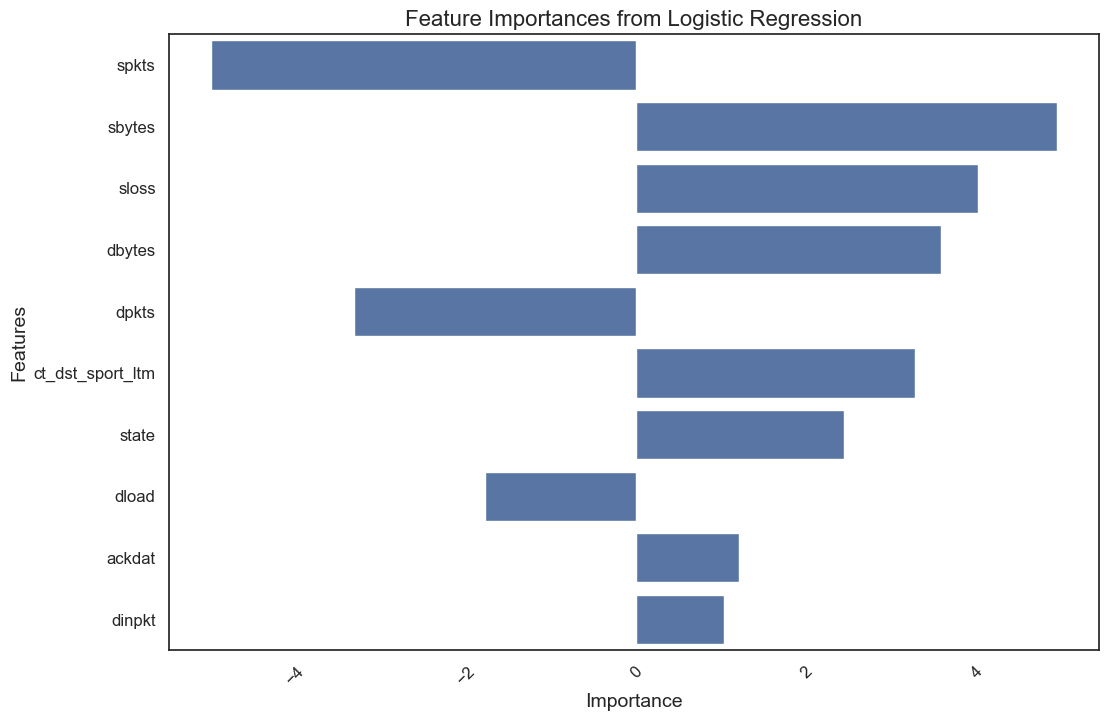

In [32]:
# Get the feature importances (coefficients)
feature_importance = model.coef_[0]

# Creating a DataFrame for easier visualization
importance_df = pd.DataFrame({'Feature': original_feature_names, 'Importance': feature_importance})

# Sorting features by the absolute value of importance
importance_df['abs_importance'] = importance_df['Importance'].abs()
importance_df = importance_df.sort_values(by='abs_importance', ascending=False).drop('abs_importance', axis=1)

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Feature Importances from Logistic Regression', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.show()


### Random Forest

In [33]:
# Create the classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Combine using numpy
X_train_val = np.concatenate([X_train, X_val])
y_train_val = np.concatenate([y_train, y_val])

# Perform k-fold cross-validation using the combined training and validation sets
k = 10
scores = cross_val_score(classifier, X_train_val, y_train_val, cv=k, scoring='accuracy')

# Evaluate the model performance from cross-validation
mean_accuracy = scores.mean()
std_accuracy = scores.std()

print(f'Mean Accuracy (Cross-Validation): {mean_accuracy:.2f}')
print(f'Standard Deviation: {std_accuracy:.2f}')

# Train the final model on the training set
classifier.fit(X_train, y_train)

# Predict and evaluate on the validation set
y_val_pred = classifier.predict(X_val)
accuracy_val = accuracy_score(y_val, y_val_pred)
precision_val = precision_score(y_val, y_val_pred)
recall_val = recall_score(y_val, y_val_pred)
f1_val = f1_score(y_val, y_val_pred)

print("\nValidation Set Performance:")
print(f'Accuracy: {accuracy_val:.2f}')
print(f'Precision: {precision_val:.2f}')
print(f'Recall: {recall_val:.2f}')
print(f'F1-Score: {f1_val:.2f}')

# Predict and evaluate on the test set
y_test_pred = classifier.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)

print("\nTest Set Performance:")
print(f'Accuracy: {accuracy_test:.2f}')
print(f'Precision: {precision_test:.2f}')
print(f'Recall: {recall_test:.2f}')
print(f'F1-Score: {f1_test:.2f}')

# Print Classification Report
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

Mean Accuracy (Cross-Validation): 0.98
Standard Deviation: 0.00

Validation Set Performance:
Accuracy: 0.98
Precision: 0.99
Recall: 0.99
F1-Score: 0.99

Test Set Performance:
Accuracy: 0.95
Precision: 0.94
Recall: 1.00
F1-Score: 0.97

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      0.82      0.90      5821
           1       0.94      1.00      0.97     17450

    accuracy                           0.95     23271
   macro avg       0.97      0.91      0.94     23271
weighted avg       0.96      0.95      0.95     23271



In [59]:

joblib.dump(classifier,'labelmodel.joblib')



['labelmodel.joblib']

In [73]:

ct =classifier.predict(X_train)
unique_values, counts = np.unique(ct, return_counts=True)  # Get unique values and their counts

# Combine the unique values and their counts into a dictionary for easier reading
value_counts = dict(zip(unique_values, counts))

print(value_counts)
xmlq = pd.DataFrame(X_train)
xmlq.to_excel('testing.xlsx', index=False)

{0: 17439, 1: 52371}


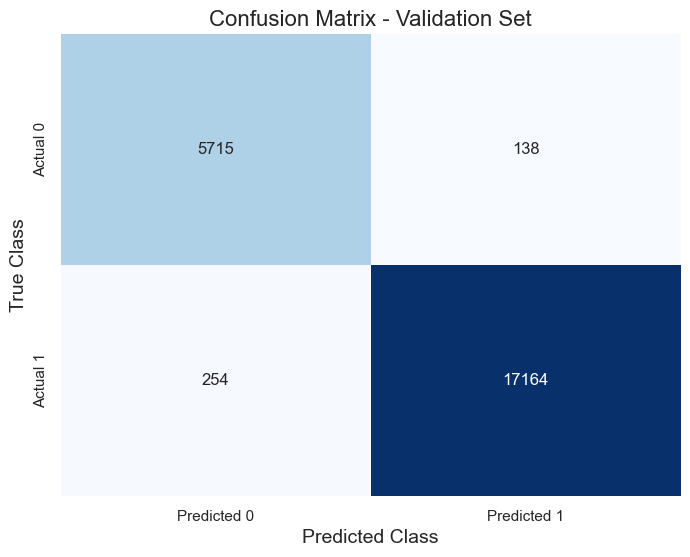

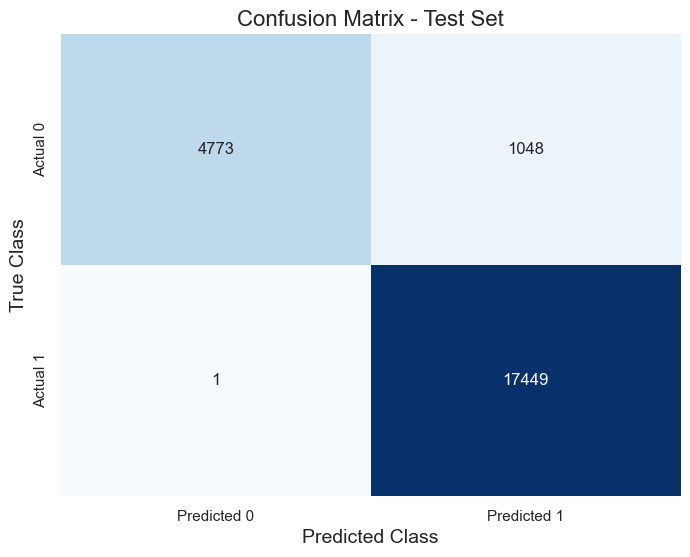

In [34]:
# Confusion Matrix for the validation set
conf_matrix_val = confusion_matrix(y_val, y_val_pred)

# Confusion Matrix for the test set
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

# Visualization for the validation set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix - Validation Set', fontsize=16)
plt.xlabel('Predicted Class', fontsize=14)
plt.ylabel('True Class', fontsize=14)
plt.show()

# Visualization for the test set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix - Test Set', fontsize=16)
plt.xlabel('Predicted Class', fontsize=14)
plt.ylabel('True Class', fontsize=14)
plt.show()


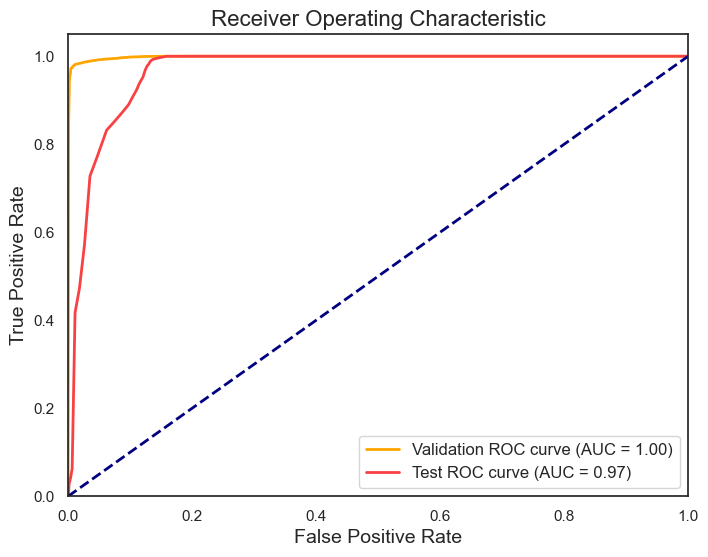

In [35]:
# ROC Curve and AUC for the validation set
y_val_pred_prob = classifier.predict_proba(X_val)[:,1]
fpr_val, tpr_val, _ = roc_curve(y_val, y_val_pred_prob)
roc_auc_val = auc(fpr_val, tpr_val)

# ROC Curve and AUC for the test set
y_test_pred_prob = classifier.predict_proba(X_test)[:,1]
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_prob)
roc_auc_test = auc(fpr_test, tpr_test)

# Plotting ROC curve for the validation set
plt.figure(figsize=(8, 6))
plt.plot(fpr_val, tpr_val, color='orange', lw=2, label=f'Validation ROC curve (AUC = {roc_auc_val:.2f})')

# Plotting ROC curve for the test set
plt.plot(fpr_test, tpr_test, color='#f94144', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')

# Plotting the diagonal line for reference
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()



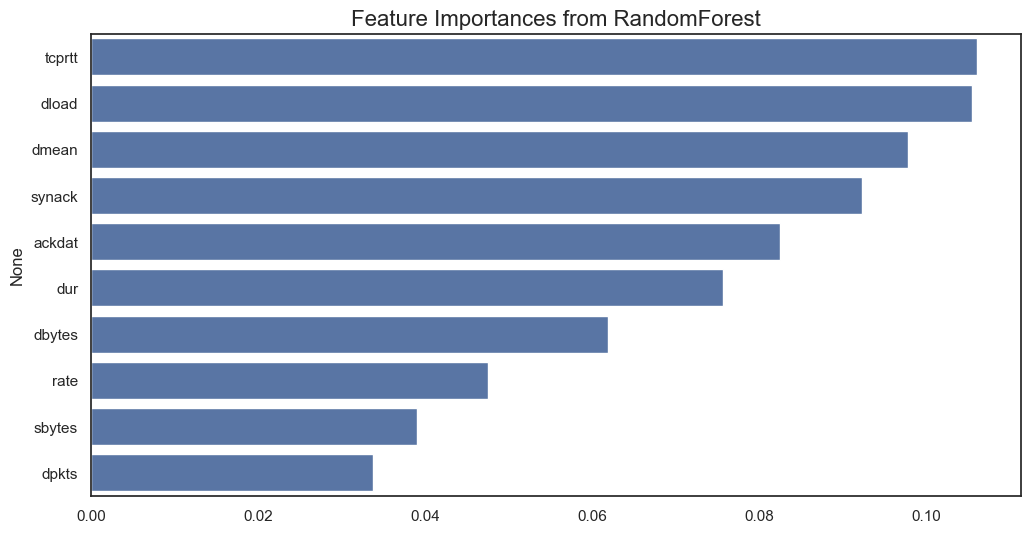

In [36]:
# Define the number of features to show
top_k = min(10, len(original_feature_names))

# Plot Feature Importances for RandomForest
rf_importances = classifier.feature_importances_
indices_rf = np.argsort(rf_importances)[::-1][:top_k]
plt.figure(figsize=(12, 6))
sns.barplot(x=rf_importances[indices_rf], y=original_feature_names[indices_rf])
plt.title('Feature Importances from RandomForest', fontsize=16)
plt.show()


# XGBoost attack binary classifier


In [37]:
# Initialize and train an XGBoost Classifier
xgb_classifier = XGBClassifier(use_label_encoder=True, eval_metric='mlogloss')
xgb_classifier.fit(X_train, y_train)

# Perform k-fold cross-validation using the combined training and validation sets
k = 10
scores = cross_val_score(xgb_classifier, X_train_val, y_train_val, cv=k, scoring='accuracy')

# Evaluate the model performance from cross-validation
mean_accuracy = scores.mean()
std_accuracy = scores.std()

print(f'Mean Accuracy (Cross-Validation): {mean_accuracy:.2f}')
print(f'Standard Deviation: {std_accuracy:.2f}')

# Predict and evaluate on the validation set
y_val_pred = xgb_classifier.predict(X_val)
accuracy_val = accuracy_score(y_val, y_val_pred)
precision_val = precision_score(y_val, y_val_pred)
recall_val = recall_score(y_val, y_val_pred)
f1_val = f1_score(y_val, y_val_pred)

print("\nValidation Set Performance:")
print(f'Accuracy: {accuracy_val:.2f}')
print(f'Precision: {precision_val:.2f}')
print(f'Recall: {recall_val:.2f}')
print(f'F1-Score: {f1_val:.2f}')

# Predict and evaluate on the test set
y_test_pred = xgb_classifier.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)

print("\nTest Set Performance:")
print(f'Accuracy: {accuracy_test:.2f}')
print(f'Precision: {precision_test:.2f}')
print(f'Recall: {recall_test:.2f}')
print(f'F1-Score: {f1_test:.2f}')

# Print Classification Report for Test Set
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix for Test Set
print("Confusion Matrix (Test Set):")
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
print(conf_matrix_test)


C:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:53:08] WAR

Mean Accuracy (Cross-Validation): 0.98
Standard Deviation: 0.00

Validation Set Performance:
Accuracy: 0.98
Precision: 0.99
Recall: 0.99
F1-Score: 0.99

Test Set Performance:
Accuracy: 0.88
Precision: 0.86
Recall: 1.00
F1-Score: 0.92

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.98      0.51      0.67      5821
           1       0.86      1.00      0.92     17450

    accuracy                           0.88     23271
   macro avg       0.92      0.75      0.80     23271
weighted avg       0.89      0.88      0.86     23271

Confusion Matrix (Test Set):
[[ 2968  2853]
 [   48 17402]]


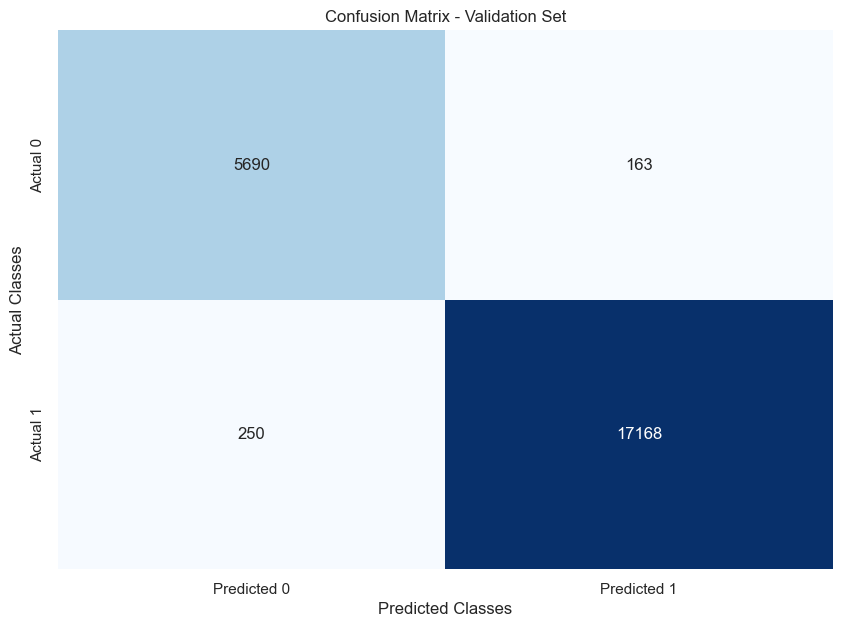

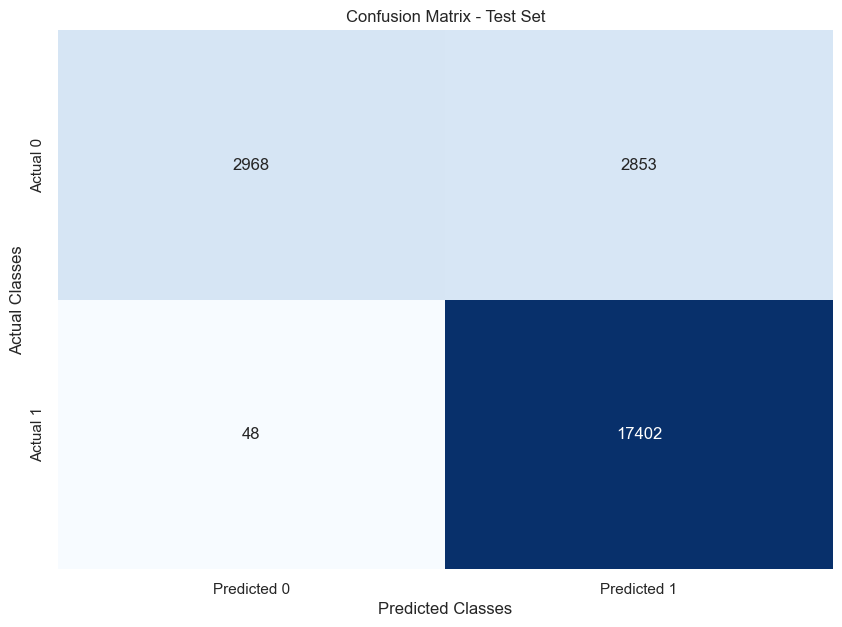

In [38]:
# Confusion Matrix for the validation set
conf_matrix_val = confusion_matrix(y_val, y_val_pred)

# Confusion Matrix for the test set
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

# Visualization for the validation set
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix - Validation Set')
plt.ylabel('Actual Classes')
plt.xlabel('Predicted Classes')
plt.show()

# Visualization for the test set
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix - Test Set')
plt.ylabel('Actual Classes')
plt.xlabel('Predicted Classes')
plt.show()

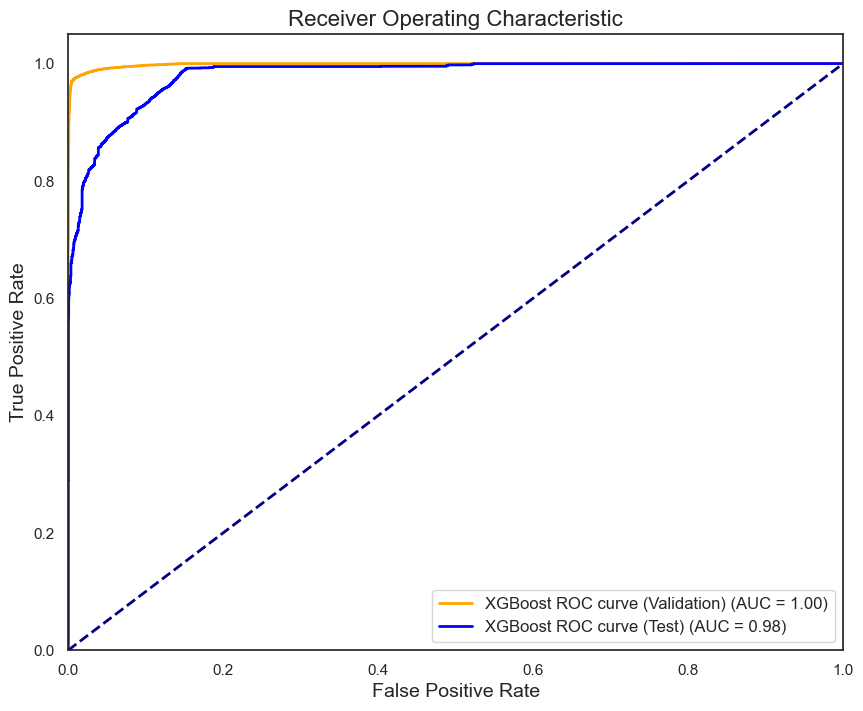

In [39]:
# Calculate ROC and AUC for the validation set
y_pred_prob_xgb_val = xgb_classifier.predict_proba(X_val)[:, 1]
fpr_xgb_val, tpr_xgb_val, _ = roc_curve(y_val, y_pred_prob_xgb_val)
roc_auc_xgb_val = roc_auc_score(y_val, y_pred_prob_xgb_val)

# Calculate ROC and AUC for the test set
y_pred_prob_xgb_test = xgb_classifier.predict_proba(X_test)[:, 1]
fpr_xgb_test, tpr_xgb_test, _ = roc_curve(y_test, y_pred_prob_xgb_test)
roc_auc_xgb_test = roc_auc_score(y_test, y_pred_prob_xgb_test)

# Plot the Curve
plt.figure(figsize=(10, 8))
plt.plot(fpr_xgb_val, tpr_xgb_val, color='orange', lw=2, label=f'XGBoost ROC curve (Validation) (AUC = {roc_auc_xgb_val:.2f})')
plt.plot(fpr_xgb_test, tpr_xgb_test, color='blue', lw=2, label=f'XGBoost ROC curve (Test) (AUC = {roc_auc_xgb_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.show()


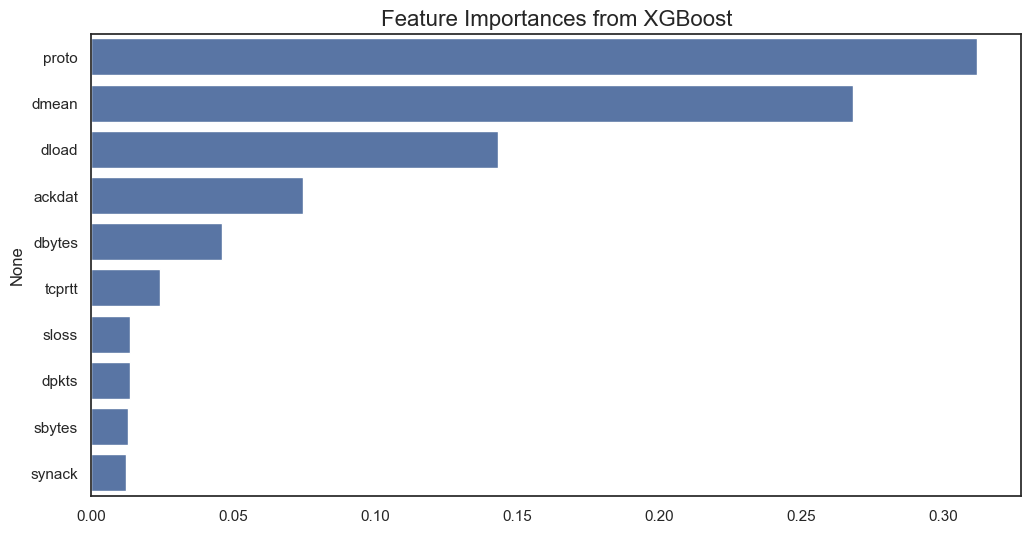

In [40]:
# Define the number of features to show
top_k = min(10, len(original_feature_names))

# Plot Feature Importances for XGBoost
xgb_importances = xgb_classifier.feature_importances_
indices_xgb = np.argsort(xgb_importances)[::-1][:top_k]
plt.figure(figsize=(12, 6))
sns.barplot(x=xgb_importances[indices_xgb], y=original_feature_names[indices_xgb])
plt.title('Feature Importances from XGBoost', fontsize=16)
plt.show()


# Multi-class Classification

## Random Forest

Preparing new dataset for multi-class classification

In [41]:
# One-hot encode categorical variables
df1 = pd.get_dummies(df1, columns=['proto', 'service', 'state'])

# Define features (X) and target (y)
X_1 = df1.drop(['attack_cat', "label"], axis=1)
y_1 = df1['attack_cat']

# Applying log-transformation for the skewed data
X_1_log = X_1.apply(lambda x: np.log(x + 1))

# Scale the features
X_scaled = scaler.fit_transform(X_1_log)

# Split data into training, validation, and testing sets
X_train_full, X_test_1, y_train_full, y_test_1 = train_test_split(X_scaled, y_1, test_size=0.2, random_state=42)
X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

In [42]:
# Initialize and train a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Perform k-fold cross-validation
k = 10
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
scores = cross_val_score(rf_classifier, X_train_full, y_train_full, cv=cv, scoring='accuracy')

# Evaluate the model's cross-validation performance
mean_accuracy = scores.mean()
std_accuracy = scores.std()
print(f'Mean Accuracy: {mean_accuracy:.2f}')
print(f'Standard Deviation: {std_accuracy:.2f}')

# Train the final model on the training set
rf_classifier.fit(X_train_1, y_train_1)

# Predict and evaluate on the validation set
y_val_pred = rf_classifier.predict(X_val_1)
accuracy_val = accuracy_score(y_val_1, y_val_pred)
print("\nValidation Set Performance:")
print(f'Accuracy: {accuracy_val:.2f}')

# Predict and evaluate on the test set
y_pred_1 = rf_classifier.predict(X_test_1)
accuracy_1 = accuracy_score(y_test_1, y_pred_1)
classification_report_str_1 = classification_report(y_test_1, y_pred_1)

# Final model performance and classification report
print("\nFinal Model Performance:")
print(f'Accuracy: {accuracy_1:.2f}')
print('Classification Report:')
print(classification_report_str_1)

Mean Accuracy: 0.94
Standard Deviation: 0.00

Validation Set Performance:
Accuracy: 0.94

Final Model Performance:
Accuracy: 0.94
Classification Report:
                precision    recall  f1-score   support

      Analysis       0.98      0.40      0.57       105
      Backdoor       1.00      0.14      0.24        22
           DoS       0.63      0.23      0.34       530
      Exploits       0.85      0.93      0.89      4375
       Fuzzers       0.72      0.73      0.73       425
       Generic       1.00      0.99      1.00     11506
        Normal       0.96      0.98      0.97      5821
Reconnaissance       0.60      0.55      0.57       463
         Worms       0.33      0.08      0.13        24

      accuracy                           0.94     23271
     macro avg       0.78      0.56      0.60     23271
  weighted avg       0.94      0.94      0.94     23271



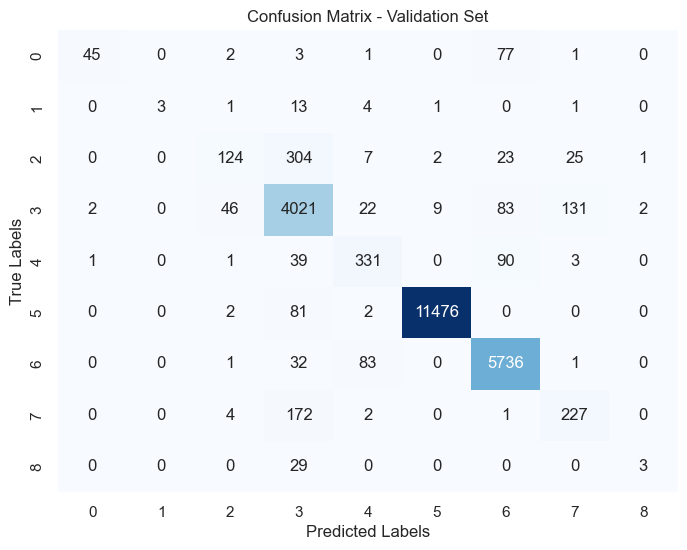

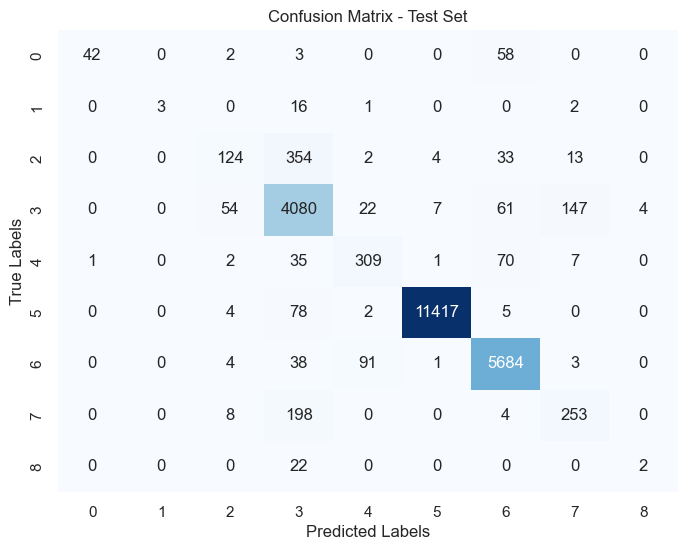

In [43]:
# Confusion Matrix for the validation set
conf_matrix_val = confusion_matrix(y_val_1, y_val_pred)

# Confusion Matrix for the test set
conf_matrix_test = confusion_matrix(y_test_1, y_pred_1)

# Visualization for the validation set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Validation Set')
plt.show()

# Visualization for the test set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Test Set')
plt.show()


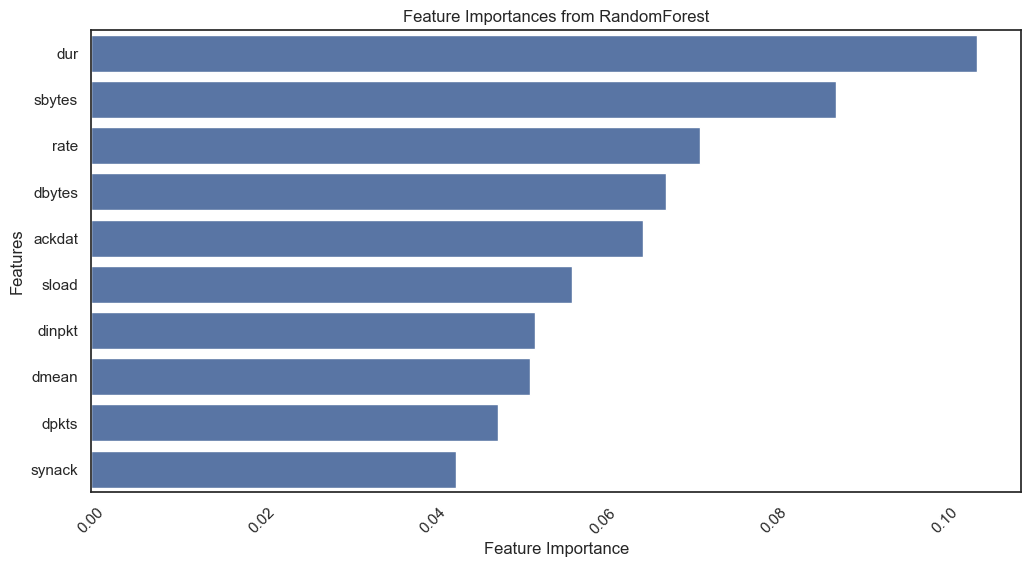

In [44]:
# Define the number of top features to display
top_k = min(10, len(X_1.columns))

# Plot feature importances from RandomForest
feature_importances = rf_classifier.feature_importances_
indices = feature_importances.argsort()[::-1]

plt.figure(figsize=(12, 6))
sns.barplot(x=feature_importances[indices][:top_k], y=X_1.columns[indices][:top_k])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importances from RandomForest')
plt.xticks(rotation=45)
plt.show()

## XGBoost

In [45]:
# Encode the target variable
label_encoder = LabelEncoder()
y_1_encoded = label_encoder.fit_transform(y_1)

# Splitting data
X_train_full, X_test_1, y_train_full, y_test_1 = train_test_split(X_scaled, y_1_encoded, test_size=0.2, random_state=42)
X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

In [46]:
# Initialize and train the XGBoost classifier
xgb_classifier_2 = XGBClassifier(objective='multi:softprob', num_class=len(np.unique(y_1_encoded)))

# Perform k-fold cross-validation
k = 10
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
scores = cross_val_score(xgb_classifier_2, X_train_full, y_train_full, cv=cv, scoring='accuracy')

# Evaluate the model's cross-validation performance
mean_accuracy = scores.mean()
std_accuracy = scores.std()
print(f'Mean Accuracy: {mean_accuracy:.2f}')
print(f'Standard Deviation: {std_accuracy:.2f}')

# Train the final model
xgb_classifier_2.fit(X_train_1, y_train_1)

# Predict and evaluate on the validation set
y_val_pred_xgb = xgb_classifier_2.predict(X_val_1)
y_val_pred_decoded = label_encoder.inverse_transform(y_val_pred_xgb)
accuracy_val_xgb = accuracy_score(y_val_1, y_val_pred_xgb)
print("\nValidation Set Performance:")
print(f'Accuracy: {accuracy_val_xgb:.2f}')

# Predict and evaluate on the test set
y_pred_xgb = xgb_classifier_2.predict(X_test_1)
y_pred_decoded = label_encoder.inverse_transform(y_pred_xgb)
accuracy_xgb = accuracy_score(y_test_1, y_pred_xgb)

# Decode the true labels in the test set for a readable classification report
y_test_1_decoded = label_encoder.inverse_transform(y_test_1)

# Classification report using decoded labels
classification_report_str_xgb = classification_report(y_test_1_decoded, y_pred_decoded)
print("\nFinal Model Performance:")
print(f'Accuracy: {accuracy_xgb:.2f}')
print('Classification Report:')
print(classification_report_str_xgb)

Mean Accuracy: 0.94
Standard Deviation: 0.00

Validation Set Performance:
Accuracy: 0.94

Final Model Performance:
Accuracy: 0.94
Classification Report:
                precision    recall  f1-score   support

      Analysis       0.93      0.40      0.56       105
      Backdoor       1.00      0.09      0.17        22
           DoS       0.61      0.22      0.32       530
      Exploits       0.85      0.93      0.89      4375
       Fuzzers       0.70      0.71      0.70       425
       Generic       1.00      0.99      1.00     11506
        Normal       0.96      0.98      0.97      5821
Reconnaissance       0.58      0.53      0.56       463
         Worms       0.50      0.33      0.40        24

      accuracy                           0.94     23271
     macro avg       0.79      0.58      0.62     23271
  weighted avg       0.94      0.94      0.93     23271



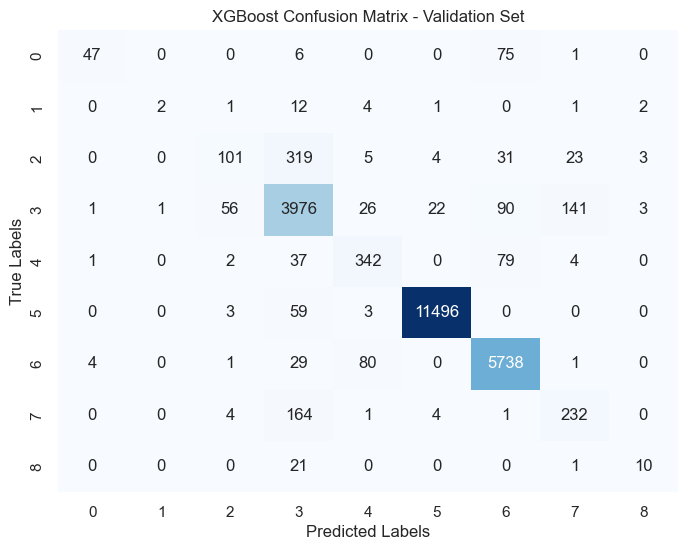

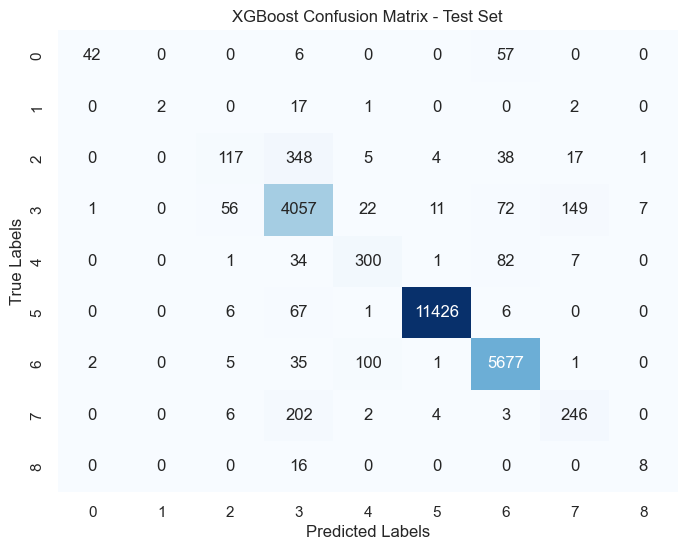

In [47]:
# Confusion Matrix for the validation set ns
conf_matrix_val_xgb = confusion_matrix(y_val_1, y_val_pred_xgb)

# Confusion Matrix for the test set
conf_matrix_test_xgb = confusion_matrix(y_test_1, y_pred_xgb)

# Visualization for the validation set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_val_xgb, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('XGBoost Confusion Matrix - Validation Set')
plt.show()

# Visualization for the test set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test_xgb, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('XGBoost Confusion Matrix - Test Set')
plt.show()


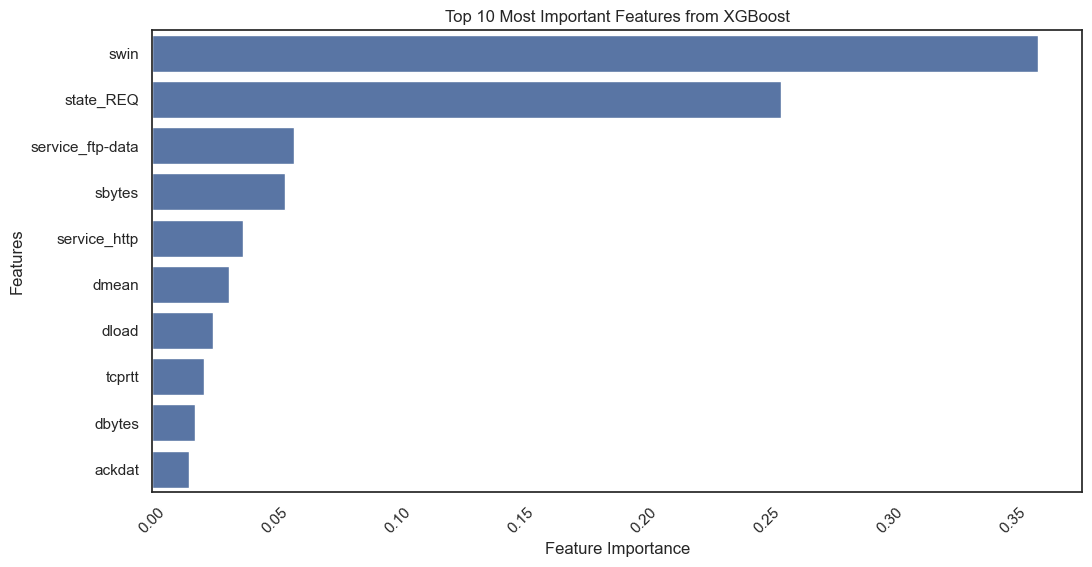

In [48]:
# Get feature importances from the XGBoost classifier
importance = xgb_classifier_2.feature_importances_

# Ensure you have the correct feature names from the original DataFrame before scaling and transformation
feature_names = X_1.columns

# Convert the feature importances to a DataFrame
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importance})

# Sort the DataFrame by importance in descending order
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Select the top 10 features
top_10_features = feature_importance.head(10)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=top_10_features)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Most Important Features from XGBoost')
plt.xticks(rotation=45)
plt.show()


## Scatterplots with RF attack cattegory feature importance

In [49]:
label_dict = {
    0: 'Analysis',
    1: 'Backdoor',
    2: 'DoS',
    3: 'Exploits',
    4: 'Fuzzers',
    5: 'Generic',
    6: 'Normal',
    7: 'Reconnaissance',
    8: 'Worms'
}

# Replace numeric labels in the DataFrame
df1['attack_cat'] = df1['attack_cat'].map(label_dict)

C:\Users\badal\AppData\Local\Temp\ipykernel_21740\1640022382.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=df1, x="sbytes", y="dur", hue="attack_cat",
C:\Users\badal\AppData\Local\Temp\ipykernel_21740\1640022382.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Attack Category')


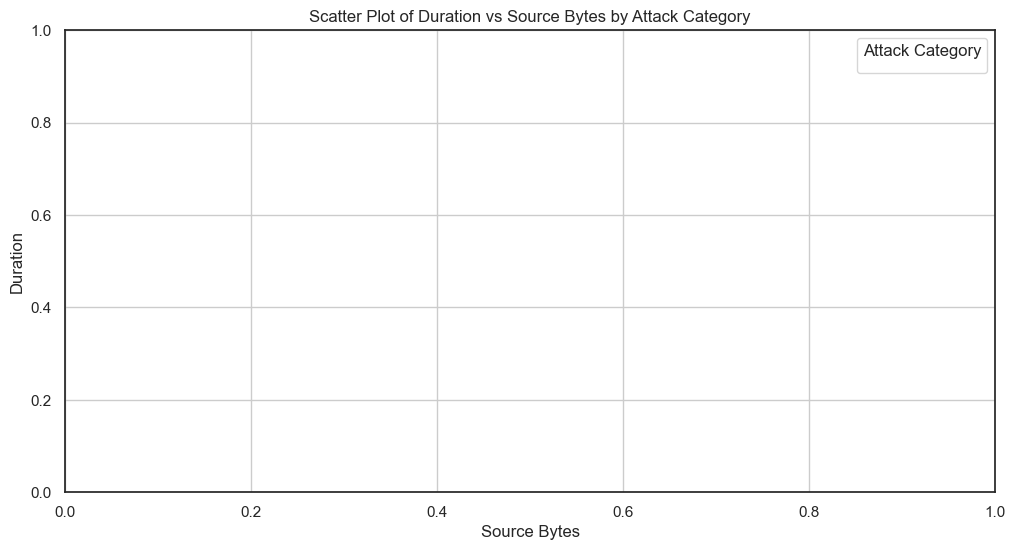

In [50]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df1, x="sbytes", y="dur", hue="attack_cat",
                palette=color_palette[:9])

plt.xlabel('Source Bytes')
plt.ylabel('Duration')
plt.title('Scatter Plot of Duration vs Source Bytes by Attack Category')
plt.legend(title='Attack Category')
plt.grid(True)
plt.show()
# Confusing

In [51]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df1, x="dbytes", y="dttl", hue="attack_cat",
                palette=color_palette[:9])

plt.xlabel('Destination Bytes')
plt.ylabel('Destination Time to Live (dTTL)')
plt.title('Scatter Plot of Destination Time to Live vs Destination Bytes by Attack Category')
plt.legend(title='Attack Category')
plt.grid(True)
plt.show()

#Dos stands out, aswell as normal

ValueError: Could not interpret value `dttl` for `y`. An entry with this name does not appear in `data`.

<Figure size 1200x600 with 0 Axes>

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df1, x="dur", y="dbytes", hue="attack_cat",
                palette=color_palette[:9])

plt.xlabel('Destination Bytes')
plt.ylabel('Destination Time to Live (dTTL)')
plt.title('Scatter Plot of Destination Time to Live vs Destination Bytes by Attack Category')
plt.legend(title='Attack Category')
plt.grid(True)
plt.show()

#normal and exploits stand out

## Boxplot for RF Attack category feature importance

In [ ]:
plt.figure(figsize=(11, 5))  # Adjust the size

sns.boxplot(data = df1, y = "dur", x = "attack_cat")

plt.title("Boxplot of category and Attack category")

plt.show()

In [ ]:
plt.figure(figsize=(11, 5))
sns.boxplot(data = df1, y = "sbytes", x = "attack_cat")
plt.title("Boxplot of category and Source to destination transacton bytes")
plt.show()

In [ ]:
plt.figure(figsize=(11, 5))
sns.boxplot(data = df1, y = "dttl", x = "attack_cat")
plt.title("Boxplot of category and Destination to source time to live value")
plt.show()

In [ ]:
plt.figure(figsize=(11, 5))
sns.boxplot(data = df1, y = "dbytes", x = "attack_cat")
plt.title("Boxplot of category and Destination to source transaction bytes")
plt.show()